# Intervention Model Classifier

Predict the intervention model from the pubmed abstract of a clinical trial

In [147]:
%store -r abstracts_targets

df = abstracts_targets.ix[:, ['abstract', 'pmid', 'intervention_model']]
df = df[df.intervention_model.notnull()] # filter away abstracts which don't spcify the intervention model

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 2126
Data columns (total 3 columns):
abstract              2085 non-null object
pmid                  2085 non-null object
intervention_model    2085 non-null object
dtypes: object(3)
memory usage: 65.2+ KB


In [148]:
df.groupby('intervention_model').size()

intervention_model
Crossover Assignment        157
Factorial Assignment         47
Parallel Assignment        1380
Single Group Assignment     501
dtype: int64

### View an Example from Each Class

In [149]:
labels = df.intervention_model.unique()

indexes = [df[df.intervention_model == label].iloc[0].name for label in labels]

for index in indexes:
    pm_url = 'https://www.google.com/search?q=pmid+' + df.iloc[index].pmid + '&btnI=I' # I'm Feeling Lucky
    
    print '*'*5, df.iloc[index].intervention_model, '*'*5
    print df.iloc[index].abstract
    print
    !google-chrome "{pm_url}"
    print

***** Parallel Assignment *****
D-Cycloserine, a partial agonist at the glycine site of the N-methyl-D-aspartate receptor, has demonstrated inconsistent efficacy for negative and cognitive symptoms of schizophrenia. The strongest evidence for efficacy has come from studies using D-cycloserine at a dose of 50 mg/day added to conventional antipsychotics in trials of 8 weeks duration or less. 
                 To assess the efficacy for negative symptoms and cognitive impairment of D-cycloserine augmentation of conventional antipsychotics in a 6-month trial. 
                 Fifty-five schizophrenia patients with prominent negative symptoms, treated with conventional antipsychotics, were randomly assigned to treatment with D-cycloserine 50 mg/day or placebo for 6 months in a double-blind, parallel group design. 
                 Twenty-six subjects completed the 6-month trial; drop-out rates did not differ between treatment groups. D-Cycloserine treatment did not differ from placebo trea

### Word Clouds for Each Class

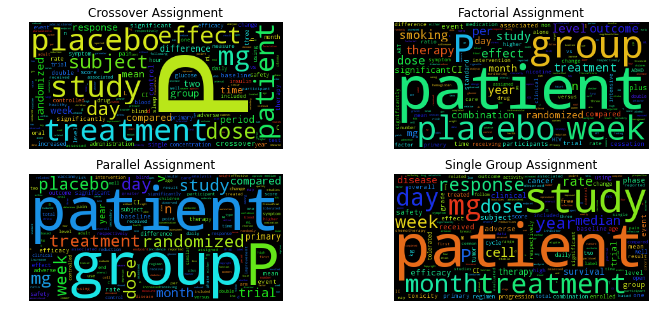

In [150]:
import wordcloud

def word_cloud(words, axes, title):
    wc = wordcloud.WordCloud().generate(words)
    axes.imshow(wc)
    axes.axis('off')
    plt.title(title)

fig = plt.figure(figsize=(12, 5))
plt.clf()

for i, label in enumerate(np.sort(df.intervention_model.unique()), start=1):
    axes = fig.add_subplot(2, 2, i)
    words = ' '.join(df[df.intervention_model == label].abstract)
    
    word_cloud(words, axes, label)
    
plt.axis('off')
plt.show()

### Fit and Transform

In [151]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2))

X = vectorizer.fit_transform(df.abstract)

X.shape

(2085, 212823)

### Extract Vocabulary and Order Vocabulary

In [152]:
import operator

vocabulary = [word for word, index in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]

### Train Test Split

In [153]:
from sklearn.cross_validation import train_test_split

X_train, X_test, ys_train, ys_test = train_test_split(X, df.intervention_model)

X_train.shape, X_test.shape, ys_train.shape, ys_test.shape

((1563, 212823), (522, 212823), (1563,), (522,))

### Train

In [154]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5, class_weight='balanced', multi_class='multinomial', solver='lbfgs')

logreg.fit(X_train, ys_train)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0)

### Prediction

In [158]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

import sklearn

predictions = logreg.predict(X_test)

sklearn.metrics.f1_score(lb.fit_transform(ys_test), lb.fit_transform(predictions), average=None)

array([ 0.34782609,  0.13333333,  0.85100287,  0.77099237])

### Confusion Matrix

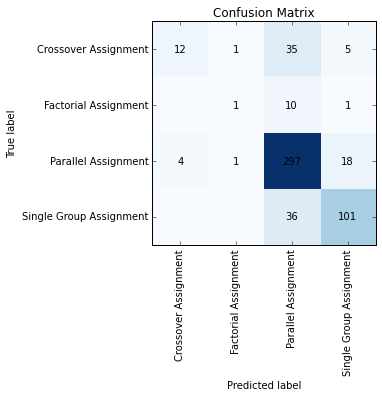

In [156]:
confusion_matrix = sklearn.metrics.confusion_matrix(ys_test, predictions)

fig = plt.figure()
plt.clf()

labels = logreg.classes_

plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')

width = height = len(labels)

for x in xrange(width):
    for y in xrange(height):
        plt.annotate(str(confusion_matrix[x][y]) if confusion_matrix[x][y] else '', xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

### Features with Highest Coefficients

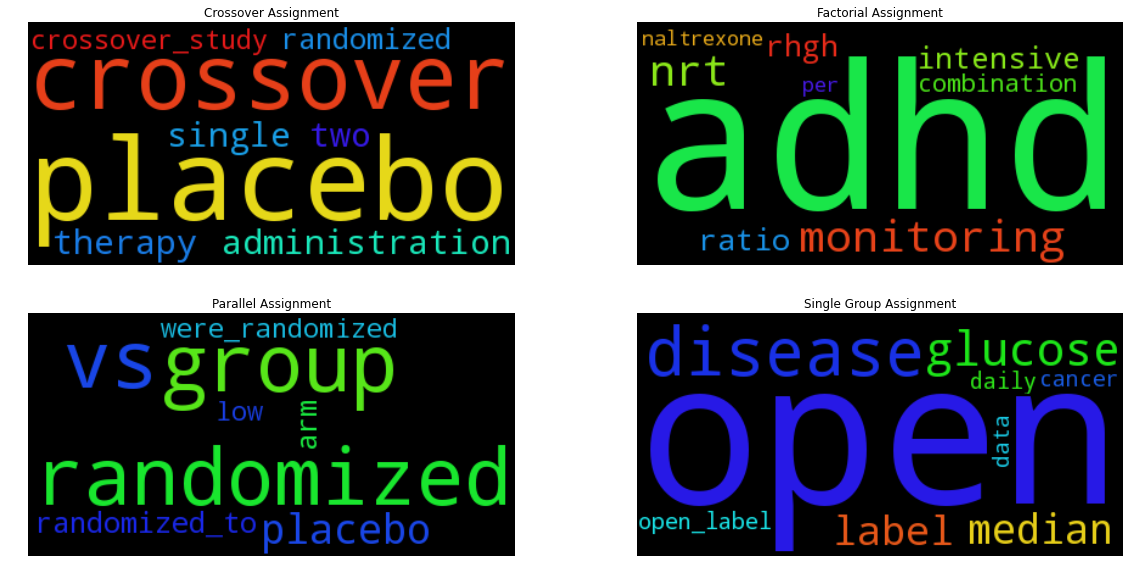

In [157]:
import re

fig = plt.figure(figsize=(20, 20))
plt.clf()

for i, (weights, title) in enumerate(zip(logreg.coef_, labels), start=1):
    pairs = sorted(zip(weights, vocabulary), reverse=True)[:10]
    pairs = [(pair[0], re.sub('\s+', '_', pair[1])) for pair in pairs]
    
    def duplicate_words(pairs):
        """Yields words duplicated proportional to their corresponding coefficients"""
        
        for coef, word in pairs:
            for _ in range(int(coef*100)):
                yield word
            
    duped_words = list(duplicate_words(pairs))
    
    axes = fig.add_subplot(4, 2, i)
    word_cloud(' '.join(duped_words), axes, title)
    
plt.axis('off')
plt.show()